In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/ANN2

/gdrive/My Drive/ANN2


In [ ]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tsaug import TimeWarp, AddNoise, Quantize, Drift, Reverse
import pickle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
label_mapping =  {'Wish':0,        #0
          'Another':1,      #1
          'Comfortably':2,  #2
          'Money':3,        #3
          'Breathe':4,      #4
          'Time':5,         #5
          'Brain':6,        #6
          'Echoes':7,       #7
          'Wearing':8,      #8
          'Sorrow':9,       #9
          'Hey':10,          #10
          'Shine':11}      #11

In [ ]:
x_train = np.load("Dataset/x_train.npy")
y_train = np.load("Dataset/y_train.npy")
#dataset.shape, labels.shape

In [ ]:
#from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

#class_weights = (class_weights - class_weights.mean()) / (class_weights.std())
#class_weights = class_weights + abs(class_weights.min()) + 1
#class_weights = [0.5 * w if w > 2 else w for w in class_weights ] 

#class_weights = {k: v for k, v in enumerate(class_weights)}
#class_weights

#class_weights = {0: 2.,
#                 1: 1.8,
#                 2: 1.,
#                 3: 2.,
#                 4: 5.,
#                 5: 3.,
#                 6: 1.3,
#                 7: 3.5,
#                 8: 1,
#                 9: 1.5,
#                 10: 1.3,
#                 11: 2.5}

In [ ]:
#x_train, y_train = shuffle(dataset, labels, random_state=0)
#indices = np.arange(dataset.shape[0])
#np.random.shuffle(indices)

#x_train = dataset[indices]
#y_train = labels[indices]

#x_train.shape, y_train.shape

In [ ]:
y_train = tfk.utils.to_categorical(y_train)
x_train.shape, y_train.shape

((2429, 36, 6), (2429, 12))

In [ ]:
#scaler1 = MinMaxScaler()
#x_train = scaler1.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#x_train.shape

scaler2 = StandardScaler()
x_train = scaler2.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#x_train.shape

#scaler2 = RobustScaler()
#x_train = scaler2.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
#x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
#x_train.shape, x_val.shape, x_test.shape

In [ ]:
#with open('minmax_scaler.pkl', 'wb') as scaler_file:
# pickle.dump(scaler1, scaler_file)

#with open('robust_scaler.pkl', 'wb') as scaler_file:
# pickle.dump(scaler2, scaler_file)

with open('standard_scaler.pkl', 'wb') as scaler_file:
  pickle.dump(scaler2, scaler_file)

In [ ]:
#x_train = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.7))])
#x_val = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.7), int(len(dataset) * 0.9))])
#x_test = np.asarray([dataset[i, :, :] for i in range(int(dataset.shape[0] * 0.9), len(dataset))])
#x_train.shape, x_val.shape, x_test.shape

In [ ]:
#y_train = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.7))])
#y_val = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.7), int(len(labels) * 0.9))])
#y_test = np.asarray([labels[i, :] for i in range(int(labels.shape[0] * 0.9), len(labels))])
#y_train.shape, y_val.shape, y_test.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.05, random_state=seed, shuffle=True, stratify=y_train)

aug_size = 5
my_augmenter = (
    TimeWarp() * aug_size  # random time warping 5 times in parallel
    + AddNoise(scale=(0.01, 0.05)) @ 0.5  # with 50% probability, add random noise up to 1% - 5%
)

x_train_aug = my_augmenter.augment(x_train)

num_samples_augmented = aug_size*x_train.shape[0]

assert(x_train_aug.shape[0] == num_samples_augmented)

x_train = np.append(x_train, x_train_aug, axis=0)

# Appending the labels of the augmented samples to the labels in the train set
y_train_aug = [y_train[i] for i in range(y_train.shape[0]) for j in range(aug_size)]
y_train = np.append(y_train, y_train_aug, axis=0)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, shuffle=True, stratify=y_train)
x_train.shape, x_val.shape, x_test.shape

((11073, 36, 6), (2769, 36, 6), (122, 36, 6))

In [ ]:
#for i in range(0, 6):
#  data = x_train[:, :, i]
#  min = data.min(axis=(1), keepdims=True)
#  max = data.max(axis=(1), keepdims=True)
#  x_train[:, :, i] = (x_train[:, :, i] - min)/(max - min)

In [ ]:
#x_train_min = x_train.min(axis=(2), keepdims=True)
#x_train_max = x_train.max(axis=(2), keepdims=True)
#(v - v_min)/(v_max - v_min)

#x_train = (x_train - x_train_min)/(x_train_max - x_train_min)
#x_val = (x_val - x_train_min)/(x_train_max - x_train_min)
#x_test = (x_test - x_train_min)/(x_train_max - x_train_min)
#x_train
#x_train_min, x_train_max

In [ ]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 8
epochs = 1000

In [ ]:
def build_1DCNN_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    conv1 = tfkl.Conv1D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling1D(pool_size=2)(conv1)
    conv1 = tfkl.Conv1D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    #gap1 = tfkl.GlobalAveragePooling1D()(conv1)
    dropout1 = tfkl.Dropout(0.2, seed=seed)(conv1)

    conv2 = tfkl.Conv1D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool2 = tfkl.MaxPooling1D(pool_size=2)(conv2)
    conv2 = tfkl.Conv1D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    #gap2 = tfkl.GlobalAveragePooling1D()(conv2)
    dropout2 = tfkl.Dropout(0.2, seed=seed)(conv2)

    conv3 = tfkl.Conv1D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool3 = tfkl.MaxPooling1D(pool_size=2)(conv3)
    conv3 = tfkl.Conv1D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    #gap3 = tfkl.GlobalAveragePooling1D()(conv3)
    dropout3 = tfkl.Dropout(0.2, seed=seed)(conv3)

    merged = tfkl.concatenate([dropout1, dropout2, dropout3], axis=2)
    merged = tfkl.GlobalAveragePooling1D()(merged)
    dropout = tfkl.Dropout(0.2, seed=seed)(merged)

    # Classifier
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.2, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=12, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 36, 64)       1216        ['Input[0][0]']                  
                                                                                                  
 conv1d_38 (Conv1D)             (None, 36, 64)       1216        ['Input[0][0]']                  
                                                                                                  
 conv1d_40 (Conv1D)             (None, 36, 64)       1216        ['Input[0][0]']                  
                                                                                              

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    #class_weight = class_weights,
    #validation_split=.2,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)
        #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/1000
1385/1385 [==============================] - 13s 9ms/step - loss: 11.1851 - accuracy: 0.2440 - val_loss: 3.2993 - val_accuracy: 0.4182
Epoch 2/1000
1385/1385 [==============================] - 11s 8ms/step - loss: 5.4920 - accuracy: 0.3788 - val_loss: 2.9331 - val_accuracy: 0.4511
Epoch 3/1000
1385/1385 [==============================] - 11s 8ms/step - loss: 3.4255 - accuracy: 0.4333 - val_loss: 1.9216 - val_accuracy: 0.5052
Epoch 4/1000
1385/1385 [==============================] - 12s 8ms/step - loss: 2.6172 - accuracy: 0.4732 - val_loss: 1.9897 - val_accuracy: 0.5164
Epoch 5/1000
1385/1385 [==============================] - 11s 8ms/step - loss: 2.2519 - accuracy: 0.4916 - val_loss: 1.6116 - val_accuracy: 0.5666
Epoch 6/1000
1385/1385 [==============================] - 11s 8ms/step - loss: 2.0390 - accuracy: 0.5126 - val_loss: 1.5774 - val_accuracy: 0.5497
Epoch 7/1000
1385/1385 [==============================] - 12s 8ms/step - loss: 1.6731 - accuracy: 0.5391 - val_loss: 

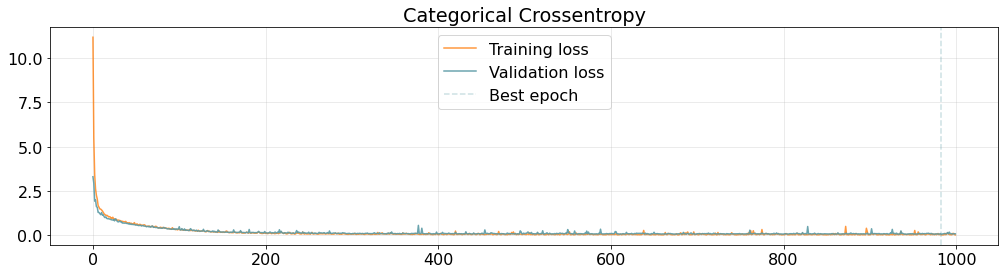

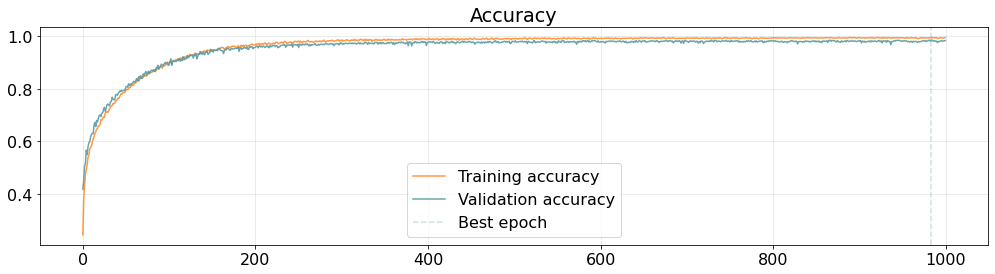

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plt.figure(figsize=(18,3))
#plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
#plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
#plt.legend()
#plt.grid(alpha=.3)
#plt.show()

In [ ]:
model.save("Models/Model1")

In [ ]:
predictions = model.predict(x_test)
predictions.shape

4/4 [==============================] - 0s 5ms/step


(122, 12)

Accuracy: 0.7541
Precision: 0.7682
Recall: 0.6499
F1: 0.6648


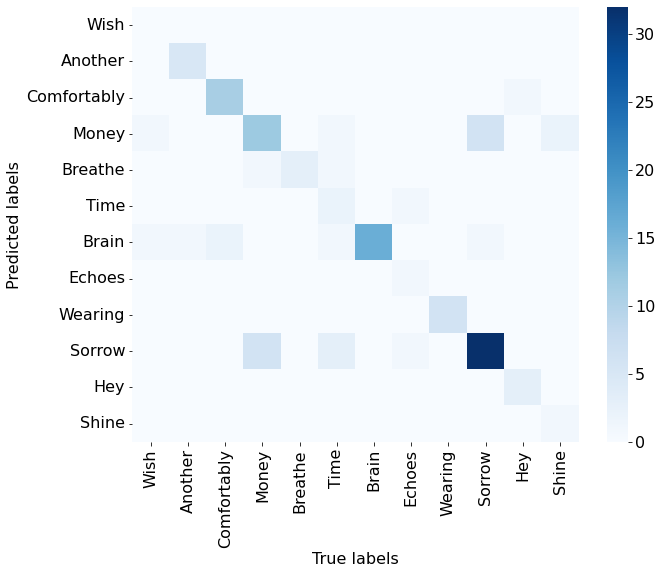

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()